In [3]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# Load your preprocessed dataset
data1 = pd.read_csv('D:/kcc_dataset.csv')

C:\Users\Admin\AppData\Local\Temp\ipykernel_13480\2452469146.py:2: DtypeWarning: Columns (1,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv('D:/kcc_dataset.csv')


In [5]:
# Filter the dataset
f_df = data1[(data1['Crop'].str.isnumeric() == False) & (data1['Crop'] != 'Others') & 
             (data1['QueryType'].str.isnumeric() == False) & (data1['QueryType'] != 'Others')]
df= pd.DataFrame(f_df)
df = df[df['Year'] >= 2013]
# Create a new feature 'Crop_QueryType'
df["place"] = df['StateName'] + '_' + df['DistrictName']
data = df[['Month', 'Year', 'place', 'Crop', 'QueryType']]


In [38]:
print(df)
print(data)

            BlockName          Category  Year  Month  Day  \
3039763   PATHAPATNAM          Oilseeds  2013      1    7   
3039867          0             Oilseeds  2013      2    8   
3039869          GARA          Oilseeds  2013      2    8   
3040001         BURJA        Vegetables  2013      4    5   
3040002   KOTABOMMILI  Plantation Crops  2013      4    5   
...               ...               ...   ...    ...  ...   
40774809        DELHI           Cereals  2024      8   19   
40774810        DELHI           Cereals  2024      8   19   
40774813        DELHI           Cereals  2024      8   19   
40774814        DELHI           Cereals  2024      8   19   
40774815        DELHI           Cereals  2024      8   19   

                                  Crop               DistrictName  \
3039763           Sunflower suryamukhi                 SRIKAKULAM   
3039867   Groundnut pea nutmung phalli                 SRIKAKULAM   
3039869   Groundnut pea nutmung phalli                 SRIKA

Crop wise Quertypes training

In [6]:
# Encode Crop_QueryType as categorical variable
data['QueryType_code'] = data['QueryType'].astype('category').cat.codes

C:\Users\Admin\AppData\Local\Temp\ipykernel_13480\702583409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['QueryType_code'] = data['QueryType'].astype('category').cat.codes


In [7]:
# Prepare input texts by using DistrictName and Crop_QueryType
data['text'] = data.apply(lambda row: f"{row['Month']} {row['place']} {row['Crop']} {row['QueryType']}", axis=1)


C:\Users\Admin\AppData\Local\Temp\ipykernel_13480\489744648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data.apply(lambda row: f"{row['Month']} {row['place']} {row['Crop']} {row['QueryType']}", axis=1)


In [8]:
# Tokenize the text inputs
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs = tokenizer(data['text'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Extract labels for training (Crop_QueryType codes)
labels = torch.tensor(data['QueryType_code'].values, dtype=torch.long)


In [9]:

train_inputs, test_inputs, train_labels, test_labels, train_idx, test_idx = train_test_split(
    inputs['input_ids'], labels, data.index, test_size=0.2, random_state=42)
train_masks, test_masks = train_test_split(inputs['attention_mask'], test_size=0.2, random_state=42)


In [10]:
# Create DataLoader for training and validation
batch_size = 16

train_data = TensorDataset(train_inputs, torch.tensor(train_masks), train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, torch.tensor(test_masks), test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13480\3377841694.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = TensorDataset(train_inputs, torch.tensor(train_masks), train_labels)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13480\3377841694.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = TensorDataset(test_inputs, torch.tensor(test_masks), test_labels)


In [11]:
# Initialize the model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=data['QueryType_code'].nunique())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
# Set up the optimizer and loss function
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()

c:\Users\Admin\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        # Compute the loss
        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()

        # Backward pass and update
        loss.backward()
        optimizer.step()

        if step % 1000 == 0:
            print(f"Epoch {epoch + 1}/{epochs} | Step {step}/{len(train_dataloader)} | Loss: {loss.item()}")

    
    
    # Calculate average loss and time taken for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    
    
    print(f"Epoch {epoch + 1}, Average Loss: {avg_train_loss}, Time Taken: {epoch_time:.2f} seconds")
    

c:\Users\Admin\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1/1 | Step 0/915532 | Loss: 4.133554935455322
Epoch 1/1 | Step 1000/915532 | Loss: 0.03110203705728054
Epoch 1/1 | Step 2000/915532 | Loss: 0.0046039461158216
Epoch 1/1 | Step 3000/915532 | Loss: 0.15722256898880005
Epoch 1/1 | Step 4000/915532 | Loss: 0.0027088611386716366
Epoch 1/1 | Step 5000/915532 | Loss: 0.008516019210219383
Epoch 1/1 | Step 6000/915532 | Loss: 0.0005387722048908472
Epoch 1/1 | Step 7000/915532 | Loss: 0.0004260171263013035
Epoch 1/1 | Step 8000/915532 | Loss: 0.0001441077038180083
Epoch 1/1 | Step 9000/915532 | Loss: 0.00011544212611624971
Epoch 1/1 | Step 10000/915532 | Loss: 0.0026145889423787594
Epoch 1/1 | Step 11000/915532 | Loss: 3.7147608964005485e-05
Epoch 1/1 | Step 12000/915532 | Loss: 0.00011600961443036795
Epoch 1/1 | Step 13000/915532 | Loss: 6.922431930433959e-05
Epoch 1/1 | Step 14000/915532 | Loss: 5.69638614251744e-05
Epoch 1/1 | Step 15000/915532 | Loss: 0.0008609023643657565
Epoch 1/1 | Step 16000/915532 | Loss: 6.749507883796468e-05
Epo

KeyboardInterrupt: 

In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask = b_input_ids.to(device), b_input_mask.to(device)
        
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(b_labels.cpu().numpy())

In [ ]:
# After prediction, use test_idx to reference the original data
predictions_flat = predictions

# Use the indices from test_idx to retrieve the original Month and DistrictName from the original data
predicted_data = pd.DataFrame({
    'Month': data.loc[test_idx, 'Month'].values, 
    'Place': data.loc[test_idx, 'place'].values,
    'Crop' : data.loc[test_idx, 'Crop'].values,
    'QueryType_code': predictions_flat
})

In [ ]:
data['QueryType'] = data['QueryType'].astype('category')
predicted_data['QueryType']=predicted_data['QueryType_code'].apply(lambda x: data['QueryType'].cat.categories[x])

In [ ]:
# Predict most frequent Crop_QueryType for next year on a monthly basis
monthly_predictions = predicted_data.groupby(['Month', 'Place', 'Crop'])['QueryType'].apply(lambda x: x.value_counts().index[:10]).reset_index()
print(monthly_predictions)

In [ ]:
monthly_predictions= monthly_predictions.explode('QueryType')
# Concatenate the QueryType values for each unique combination of Month and Place
monthly_predictions = monthly_predictions.groupby(['Month', 'Place', 'Crop'])['QueryType'].apply(lambda x: ', '.join(x)).reset_index()


In [ ]:
# Save predictions to CSV with only Month, Place, and Crop_QueryType columns
monthly_predictions[['Month', 'Place','Crop', 'QueryType']].to_csv('D:/Data/predicted_crop_wise_querytypes_in_India.csv', index=False, header=True)

In [ ]:
# Flatten the predictions and true labels
predictions = np.array(predictions)
true_labels = np.array(true_labels)

In [ ]:

def rmse(true_labels, predictions):
    return np.sqrt(np.mean((np.array(true_labels) - np.array(predictions)) ** 2))

def mae(true_labels, predictions):
    return np.mean(np.abs(np.array(true_labels) - np.array(predictions)))

def f1_score(true_labels, predictions):
    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fp = np.sum((np.array(true_labels) == 0) & (np.array(predictions) == 1))
    fn = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 0))
    
    # Calculate Precision and Recall
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    # Calculate F1-Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1

def recall(true_labels, predictions):
    # Calculate True Positives (TP) and False Negatives (FN)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fn = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 0))
    
    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return recall

def precision(true_labels, predictions):
    # Calculate True Positives (TP) and False Positives (FP)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fp = np.sum((np.array(true_labels) == 0) & (np.array(predictions) == 1))
    
    # Calculate Precision
    return tp / (tp + fp) if (tp + fp) != 0 else 0

import numpy as np

def accuracy(true_labels, predictions):
    # Count the number of correct predictions
    correct = np.sum(np.array(true_labels) == np.array(predictions))
    # Calculate accuracy
    return correct / len(true_labels)

In [ ]:
# Calculate RMSE and MAE
rmse = rmse(true_labels, predictions)
mae = mae(true_labels, predictions)

# Calculate F1-Score and Recall
f1 = f1_score(true_labels, predictions)
recall = recall(true_labels, predictions)

accuracy= accuracy(true_labels, predictions)
precision= precision(true_labels, predictions)



In [ ]:
# Create a bar plot for the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE', 'MAE']
values = [accuracy, precision, recall, f1, rsme, mae]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'Teal', 'orange'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Display the metrics in a tabular format
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE', 'MAE'],
    'Value': [accuracy, precision, recall, f1, rsme, mae]
})

print("\nModel Performance Metrics:")
print(metrics_table)

# Save the metrics to a CSV file
metrics_table.to_csv('D:/Data/bert1_model_performance_metrics.csv', index=False)

crop_querytype training

In [14]:
df["Crop_QueryType"] = df["Crop"] + "_" +df["QueryType"]
data=df[['Month','place','Crop_QueryType']]
# Encode Crop_QueryType as categorical variable
data['Crop_QueryType_code'] = data['Crop_QueryType'].astype('category').cat.codes

C:\Users\Admin\AppData\Local\Temp\ipykernel_13480\2344155238.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Crop_QueryType_code'] = data['Crop_QueryType'].astype('category').cat.codes


In [15]:
# Prepare input texts by using DistrictName and Crop_QueryType
data['text1'] = data.apply(lambda row: f"{row['Month']} {row['place']} {row['Crop_QueryType']}", axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13480\1077065516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text1'] = data.apply(lambda row: f"{row['Month']} {row['place']} {row['Crop_QueryType']}", axis=1)


In [16]:
# Tokenize the text inputs
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs1 = tokenizer(data['text1'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Extract labels for training (Crop_QueryType codes)
labels1 = torch.tensor(data['Crop_QueryType_code'].values, dtype=torch.long)

In [17]:
# Split the data without stratification
train_inputs1, test_inputs1, train_labels1, test_labels1, train_idx1, test_idx1 = train_test_split(
    inputs1['input_ids'], labels1, data.index, test_size=0.2, random_state=42)
train_masks1, test_masks1 = train_test_split(inputs1['attention_mask'], test_size=0.2, random_state=42)

In [18]:
# Create DataLoader for training and validation
batch_size = 16

train_data1 = TensorDataset(train_inputs1, torch.tensor(train_masks1), train_labels1)
train_sampler1 = RandomSampler(train_data1)
train_dataloader1 = DataLoader(train_data1, sampler=train_sampler1, batch_size=batch_size)

test_data1 = TensorDataset(test_inputs1, torch.tensor(test_masks1), test_labels1)
test_sampler1 = SequentialSampler(test_data1)
test_dataloader1 = DataLoader(test_data1, sampler=test_sampler1, batch_size=batch_size)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13480\419209612.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data1 = TensorDataset(train_inputs1, torch.tensor(train_masks1), train_labels1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13480\419209612.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data1 = TensorDataset(test_inputs1, torch.tensor(test_masks1), test_labels1)


In [19]:
# Initialize the model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=data['Crop_QueryType_code'].nunique())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
# Set up the optimizer and loss function
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()

c:\Users\Admin\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader1):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        # Compute the loss
        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()

        # Backward pass and update
        loss.backward()
        optimizer.step()

        if step % 10000== 0:
            print(f"Epoch {epoch + 1}/{epochs} | Step {step}/{len(train_dataloader1)} | Loss: {loss.item()}")

    # End time for the epoch
    # epoch_end_time = time.time()
    
    # Calculate average loss and time taken for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    # epoch_time = epoch_end_time - epoch_start_time
    
    print(f"Epoch {epoch + 1}, Average Loss: {avg_train_loss}") # Time Taken: {epoch_time:.2f} seconds")
    

Epoch 1/1 | Step 0/915532 | Loss: 8.996611595153809
Epoch 1/1 | Step 10000/915532 | Loss: 1.120590090751648
Epoch 1/1 | Step 20000/915532 | Loss: 0.4200342893600464
Epoch 1/1 | Step 30000/915532 | Loss: 0.0005468620220199227
Epoch 1/1 | Step 40000/915532 | Loss: 0.01645905151963234
Epoch 1/1 | Step 50000/915532 | Loss: 0.4551782011985779
Epoch 1/1 | Step 60000/915532 | Loss: 0.0010110278381034732
Epoch 1/1 | Step 70000/915532 | Loss: 0.00020136857347097248
Epoch 1/1 | Step 80000/915532 | Loss: 0.015328590758144855
Epoch 1/1 | Step 90000/915532 | Loss: 0.487009733915329
Epoch 1/1 | Step 100000/915532 | Loss: 0.0006027891649864614
Epoch 1/1 | Step 110000/915532 | Loss: 0.00038166833110153675
Epoch 1/1 | Step 120000/915532 | Loss: 0.00014021350943949074
Epoch 1/1 | Step 130000/915532 | Loss: 0.00010214930080110207
Epoch 1/1 | Step 140000/915532 | Loss: 0.00016501839854754508
Epoch 1/1 | Step 150000/915532 | Loss: 0.7155891060829163
Epoch 1/1 | Step 160000/915532 | Loss: 0.0009882700396701

In [ ]:
    avg_train_loss = total_loss / len(train_dataloader)
    # epoch_time = epoch_end_time - epoch_start_time
    
    print(f"Epoch {epoch + 1}, Average Loss: {avg_train_loss}")#

In [22]:
# Now make predictions for the next year
model.eval()
predictions1 = []
true_labels1 = []
with torch.no_grad():
    for batch in test_dataloader1:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask = b_input_ids.to(device), b_input_mask.to(device)
        
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions1.extend(preds)
        true_labels1.extend(b_labels.cpu().numpy())


In [25]:
# After prediction, use test_idx to reference the original data
predictions_flat1 = predictions1

# Use the indices from test_idx to retrieve the original Month and DistrictName from the original data
predicted_data1 = pd.DataFrame({
    'Month': data.loc[test_idx, 'Month'].values, 
    'Place': data.loc[test_idx, 'place'].values,
    'Crop_QueryType_code': predictions_flat1
})
print(predicted_data1)

         Month                              Place  Crop_QueryType_code
0            9             UTTAR PRADESH_FATEHPUR                 5571
1           12             ANDHRA PRADESH_NELLORE                 5554
2            5                 RAJASTHAN_BHILWARA                 4410
3           11          UTTAR PRADESH_KUSHI NAGAR                 7874
4            9                  MAHARASHTRA_NASIK                 7553
...        ...                                ...                  ...
3662122      7                TAMILNADU_CUDDALORE                 5554
3662123     12                     PUNJAB_PATIALA                 7893
3662124     11                    BIHAR_DARBHANGA                 7889
3662125      5  UTTAR PRADESH_GAUTAM BUDDHA NAGAR                 5917
3662126      8              UTTAR PRADESH_ALIGARH                 1114

[3662127 rows x 3 columns]


In [26]:
data['Crop_QueryType'] = data['Crop_QueryType'].astype('category')
predicted_data1['Crop_QueryType']=predicted_data1['Crop_QueryType_code'].apply(lambda x: data['Crop_QueryType'].cat.categories[x])
print(predicted_data1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13480\301140935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Crop_QueryType'] = data['Crop_QueryType'].astype('category')


         Month                              Place  Crop_QueryType_code  \
0            9             UTTAR PRADESH_FATEHPUR                 5571   
1           12             ANDHRA PRADESH_NELLORE                 5554   
2            5                 RAJASTHAN_BHILWARA                 4410   
3           11          UTTAR PRADESH_KUSHI NAGAR                 7874   
4            9                  MAHARASHTRA_NASIK                 7553   
...        ...                                ...                  ...   
3662122      7                TAMILNADU_CUDDALORE                 5554   
3662123     12                     PUNJAB_PATIALA                 7893   
3662124     11                    BIHAR_DARBHANGA                 7889   
3662125      5  UTTAR PRADESH_GAUTAM BUDDHA NAGAR                 5917   
3662126      8              UTTAR PRADESH_ALIGARH                 1114   

                               Crop_QueryType  
0                          Paddy Dhan_Weather  
1              

In [27]:
# Predict most frequent Crop_QueryType for next year on a monthly basis
monthly_predictions1 = predicted_data1.groupby(['Month', 'Place'])['Crop_QueryType'].apply(lambda x: x.value_counts().index[:15]).reset_index()
print(monthly_predictions1)

      Month                          Place  \
0         1        A AND N ISLANDS_NICOBAR   
1         1        ANDHRA PRADESH_ANANTPUR   
2         1        ANDHRA PRADESH_CHITTOOR   
3         1   ANDHRA PRADESH_EAST GODAVARI   
4         1          ANDHRA PRADESH_GUNTUR   
...     ...                            ...   
7756     12     WEST BENGAL_North DINAJPUR   
7757     12            WEST BENGAL_PURULIA   
7758     12  WEST BENGAL_SOUTH 24 PARGANAS   
7759     12     WEST BENGAL_South DINAJPUR   
7760     12     WEST BENGAL_WEST MEDINIPUR   

                                         Crop_QueryType  
0     Index(['Chillies_Nutrient Management', 'Ash Go...  
1     Index(['Groundnut pea nutmung phalli_Plant Pro...  
2     Index(['Paddy Dhan_Plant Protection', 'Chillie...  
3     Index(['Paddy Dhan_Plant Protection', 'Black G...  
4     Index(['Chillies_Plant Protection', 'Chillies_...  
...                                                 ...  
7756  Index(['Potato_Plant Protection', '

In [28]:
monthly_predictions1= monthly_predictions1.explode('Crop_QueryType')
# Concatenate the QueryType values for each unique combination of Month and Place
monthly_predictions1 = monthly_predictions1.groupby(['Month', 'Place'])['Crop_QueryType'].apply(lambda x: ', '.join(x)).reset_index()
print(monthly_predictions1)

      Month                          Place  \
0         1        A AND N ISLANDS_NICOBAR   
1         1        ANDHRA PRADESH_ANANTPUR   
2         1        ANDHRA PRADESH_CHITTOOR   
3         1   ANDHRA PRADESH_EAST GODAVARI   
4         1          ANDHRA PRADESH_GUNTUR   
...     ...                            ...   
7756     12     WEST BENGAL_North DINAJPUR   
7757     12            WEST BENGAL_PURULIA   
7758     12  WEST BENGAL_SOUTH 24 PARGANAS   
7759     12     WEST BENGAL_South DINAJPUR   
7760     12     WEST BENGAL_WEST MEDINIPUR   

                                         Crop_QueryType  
0     Chillies_Nutrient Management, Ash Gourd Petha_...  
1     Groundnut pea nutmung phalli_Plant Protection,...  
2     Paddy Dhan_Plant Protection, Chillies_Plant Pr...  
3     Paddy Dhan_Plant Protection, Black Gram urd be...  
4     Chillies_Plant Protection, Chillies_Nutrient M...  
...                                                 ...  
7756  Potato_Plant Protection, Maize Makk

In [29]:
# Predict most frequent Crop_QueryType for next year on a monthly basis
monthly_data1 = predicted_data1.groupby(['Month', 'Place'])['Crop_QueryType'].apply(lambda x: ', '.join(x)).reset_index()
print(monthly_data1)

      Month                          Place  \
0         1        A AND N ISLANDS_NICOBAR   
1         1        ANDHRA PRADESH_ANANTPUR   
2         1        ANDHRA PRADESH_CHITTOOR   
3         1   ANDHRA PRADESH_EAST GODAVARI   
4         1          ANDHRA PRADESH_GUNTUR   
...     ...                            ...   
7756     12     WEST BENGAL_North DINAJPUR   
7757     12            WEST BENGAL_PURULIA   
7758     12  WEST BENGAL_SOUTH 24 PARGANAS   
7759     12     WEST BENGAL_South DINAJPUR   
7760     12     WEST BENGAL_WEST MEDINIPUR   

                                         Crop_QueryType  
0     Chillies_Nutrient Management, Ash Gourd Petha_...  
1     Tomato_Plant Protection, BhindiOkraLadysfinger...  
2     Chillies_Plant Protection, Black Gram urd bean...  
3     Sugarcane Noble Cane_Weed Management, Paddy Dh...  
4     Banana_Nutrient Management, Bengal Gram GramCh...  
...                                                 ...  
7756  Maize Makka_Plant Protection, Potat

In [30]:
# Save predictions to CSV with only Month, Place, and Crop_QueryType columns
monthly_data1.to_csv('D:/Data/Places_crop_querytypes_in_India.csv', index=False, header=True)

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [32]:
# Flatten the predictions and true labels
predictions1 = np.array(predictions1)
true_labels1 = np.array(true_labels1)

In [33]:

def rmse(true_labels, predictions):
    return np.sqrt(np.mean((np.array(true_labels) - np.array(predictions)) ** 2))

def mae(true_labels, predictions):
    return np.mean(np.abs(np.array(true_labels) - np.array(predictions)))

def f1_score(true_labels, predictions):
    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fp = np.sum((np.array(true_labels) == 0) & (np.array(predictions) == 1))
    fn = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 0))
    
    # Calculate Precision and Recall
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    # Calculate F1-Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1

def recall(true_labels, predictions):
    # Calculate True Positives (TP) and False Negatives (FN)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fn = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 0))
    
    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return recall

def precision(true_labels, predictions):
    # Calculate True Positives (TP) and False Positives (FP)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fp = np.sum((np.array(true_labels) == 0) & (np.array(predictions) == 1))
    
    # Calculate Precision
    return tp / (tp + fp) if (tp + fp) != 0 else 0

import numpy as np

def accuracy(true_labels, predictions):
    # Count the number of correct predictions
    correct = np.sum(np.array(true_labels) == np.array(predictions))
    # Calculate accuracy
    return correct / len(true_labels)

In [34]:
# Calculate RMSE and MAE
rmse = rmse(true_labels1, predictions1)
mae = mae(true_labels1, predictions1)

# Calculate F1-Score and Recall
f1= f1_score(true_labels1, predictions1)
recall = recall(true_labels1, predictions1)

accuracy = accuracy(true_labels1, predictions1)
precision = precision(true_labels1, predictions1)



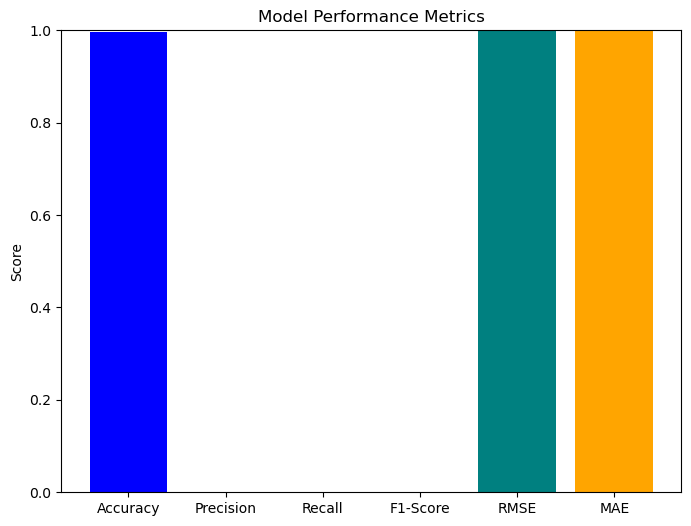


Model Performance Metrics:
      Metric       Value
0   Accuracy    0.997274
1  Precision    0.000000
2     Recall    0.000000
3   F1-Score    0.000000
4       RMSE  126.121665
5        MAE    4.056349


In [36]:
# Create a bar plot for the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE', 'MAE']
values = [accuracy, precision, recall, f1, rmse, mae]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'Teal', 'orange'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Display the metrics in a tabular format
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE', 'MAE'],
    'Value': [accuracy, precision, recall, f1, rmse, mae]
})

print("\nModel Performance Metrics:")
print(metrics_table)
# Save the metrics to a CSV file
metrics_table.to_csv('D:/Data/bert2 model_performance_metrics.csv', index=False)

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
rmse = np.sqrt(mean_squared_error(true_labels1, predictions1))
print(rmse)

126.12166489186039
